(descriptive_statistics)=

In [1]:
# import modules
import math

import matplotlib.pyplot as plt
import msprime
from IPython.display import display
from myst_nb import glue
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
# Generate example data for this chapter

ts = msprime.sim_ancestry(5, population_size=1.0, recombination_rate=0.,
                          random_seed=54321, sequence_length=10000.0,
                          discrete_genome=True)
ts = msprime.sim_mutations(ts, rate=0.25/1e4, random_seed=12345,
                           model=msprime.JC69(), discrete_genome=True)
assert ts.num_mutations > 0

# Simple descriptive statistics

## The variation table.

The most common representation of population genetic data is the *variation table*.
This table is simply a "spreadsheet" showing the DNA states at positions that are variable amongst our samples.

Below, we see an example of a variation table.
The table has the following features:

1. It is written in a matrix format.
2. Rows correspond to individual genomes.
3. Columns correspond to genomic positions that vary.
4. The elements of the matrix are the DNA state at a certain position in a certain genome.

In [3]:
alleles = ('A','C','G','T')
gmatrix = ts.genotype_matrix(alleles=alleles).T
haplotypes = np.zeros(len(gmatrix.flatten()), dtype=np.unicode_)
for i, a in enumerate(gmatrix.flatten()):
    haplotypes[i] = alleles[a]
haplotypes = haplotypes.reshape(gmatrix.shape)
print(haplotypes)

[['G' 'T' 'T' 'T']
 ['C' 'G' 'C' 'T']
 ['C' 'G' 'C' 'T']
 ['C' 'G' 'C' 'T']
 ['C' 'G' 'C' 'T']
 ['C' 'G' 'C' 'T']
 ['C' 'G' 'C' 'T']
 ['G' 'T' 'T' 'T']
 ['C' 'G' 'C' 'T']
 ['C' 'G' 'C' 'G']]


The first row corresponds to the DNA states at all variable sites for the first genome:

In [4]:
print(haplotypes[0,:])

['G' 'T' 'T' 'T']


By comparing the rows to one another, we can start to see that some genomes are identical and other differ at one or more positions.
There are ten rows, which is the number of genomes in the sample.

The columns show use the states corresponding to each *site* in each genome.
For example, the first column is:

In [5]:
print(haplotypes[:,0].reshape((haplotypes.shape[0], 1)))
glue("first_genome_first_site", haplotypes[:,0][0], display=False)
glue("second_genome_first_site", haplotypes[:,0][1], display=False)

[['G']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['C']
 ['G']
 ['C']
 ['C']]


'G'

'C'

Starting from the top, the first entry, {glue:text}`first_genome_first_site`, is the DNA state at the first variable site in the first genome.
The second entry, {glue:text}`second_genome_first_site`, is the DNA state at the first variable site in the second genome.
Etc..

Our table is missing some important things:

1. The positions are omitted.
   How the positions are stored is a bioinformatic issue and will have to consider both the chromosome and the position along the chromosome.
2. Sample *labels* are also missing.
   We are being intentionally vague/general here.
   For example, the table could consist of ten haploid genomes.
   Or, it could consist of five diploid genomes with each pair of rows representing the maternal/paternal genomes of an individual.
   In practice, we need row labels in order to make full use of the data.

A fuller representation of our data may thus look like the following, with columns labelled by position and rows labelled by sample identifier:

In [6]:
data = dict()
for i, s in enumerate(ts.sites()):
    data[int(s.position)] = haplotypes[:, i]

df = pd.DataFrame(data)
df.index = ['sample ' + str(i) for i in range(len(df.index))]

display(df)

,83,1064,2987,6531
sample 0,G,T,T,T
sample 1,C,G,C,T
sample 2,C,G,C,T
sample 3,C,G,C,T
sample 4,C,G,C,T
sample 5,C,G,C,T
sample 6,C,G,C,T
sample 7,G,T,T,T
sample 8,C,G,C,T
sample 9,C,G,C,G


## Recoding the data

It is often inconvenient to work with the data in the form shown above. 
For reasons having to do with efficient computation, it is often useful to recode the data.
For example, we may choose to replace `A`, `C`, `G` and `T` with `0`, `1`, `2` and `3`, respectively:

In [7]:
print(gmatrix)

[[2 3 3 3]
 [1 2 1 3]
 [1 2 1 3]
 [1 2 1 3]
 [1 2 1 3]
 [1 2 1 3]
 [1 2 1 3]
 [2 3 3 3]
 [1 2 1 3]
 [1 2 1 2]]


There is no loss of generality here.
Rather, these recodings are practical matters that you are likely to run across when analyzing data.
Various programs will expect the data to be encoded in a certain way.
Fortunately, some standards are emerging.
See {ref}`here <variation_data_bioinformatics>`.

## The number of variable sites

In [8]:
glue("S", haplotypes.shape[0], display=False)

10

The simplest summary of the data is a tally of the number of variable positions.
For our example data set, this number is {glue:text}`S`.

This statistic can be referred to by many synonyms, including:

* The number of polymorphic sites
* The number of segregating sites, where "segregation" is a term from Mendelian genetics.
  This term is most famously associated with the paper by {cite:t}`Watterson1975-ej`.

## The number of pairwise differences

In [9]:
ndiffs = 0
for i in range(gmatrix.shape[0]):
    for j in range(i + 1, gmatrix.shape[0]):
        for k,l in zip(gmatrix[i,:], gmatrix[j,:]):
            if k != l:
                ndiffs += 1
ncomps = gmatrix.shape[0] * (gmatrix.shape[0] - 1) / 2
ndiffs = ndiffs / ncomps
tsdiv = ts.diversity([[i for i in ts.samples()]], span_normalise=False)[0]
assert math.isclose(ndiffs, tsdiv), f"{ndiffs} {tsdiv}"
glue("mean_diffs", np.round(ndiffs, 4), display=False)

1.2667

We are often concerned with how different our sample genomes are.
A natural summary of the data then is the mean number of differences between all pairs of genomes.
(Here, a pair never includes the same genome compared to itself).
To calculate this value, one compares each genome to all others in the sample.
For each pair, count the number of differences and divide by the number of pairs to get the mean.
For the example data, this value is {glue:text}`mean_diffs`.

The explicit formula for this statistic is {math}`\pi = \frac{\sum_{i=1}^{n-1}\sum_{j=i+1}^{n}D_{ij}}{C}`, where $D_{ij}$ is the number of differences between genomes {math}`i` and {math}`j` and {math}`C = {n \choose 2} = \frac{n(n-1)}{2}` for {math}`n` genomes.  The term {math}`C` is the number of pairs.

TODO Citations: Nei and Tajima.

## Heterozygosity

In [10]:
counts_site_0 = np.unique(haplotypes[:,0], return_counts=True)
counts_site_0

het_site_0 = 0.0

nsam = haplotypes.shape[0]

for c in counts_site_0[1]:
    het_site_0 += c * (nsam - c)
het_site_0 /= (nsam * (nsam - 1))

print(counts_site_0, het_site_0)

(array(['C', 'G'], dtype='<U1'), array([8, 2])) 0.35555555555555557


## Homozygosity

In [11]:
hom_site_0 = 0.0
for c in counts_site_0[1]:
    hom_site_0 += (c/haplotypes.shape[0])*((c - 1)/(haplotypes.shape[0]-1))

assert math.isclose(het_site_0, 1.0 - hom_site_0)

print(hom_site_0, 1.0 - hom_site_0)

0.6444444444444445 0.3555555555555555


## Normalizing by the length of a genomic region

## Ancestral/derived and minor/major alleles

The ancestral and derived states in our example data are known:

In [12]:
for i in ts.sites():
    print(f"Site index {i.id} has ancestral state {i.ancestral_state}")

Site index 0 has ancestral state G
Site index 1 has ancestral state T
Site index 2 has ancestral state T
Site index 3 has ancestral state T


The derived states are:

In [13]:
for i in ts.mutations():
    print(f"Mutation {i.id} at site index {i.site} has derived state {i.derived_state}")

Mutation 0 at site index 0 has derived state C
Mutation 1 at site index 1 has derived state G
Mutation 2 at site index 2 has derived state C
Mutation 3 at site index 3 has derived state G


Using the convention of representing the ancestral state as `0` and all derived states as integer values greater than `0`, we can rewrite our data matrix as follows:

In [14]:
derived_state_map = dict()
unfolded_fs = []
for i in ts.mutations():
    if i.id not in derived_state_map:
        derived_state_map[i.id] = [i.derived_state]
    else:
        derived_state_map[i.id].append(i.derived_state)

recoded_matrix_ancestral_derived = []
for site in range(haplotypes.shape[1]):
    for state in haplotypes[:,site]:
        if state in derived_state_map[site]:
            recoded_matrix_ancestral_derived.append(derived_state_map[site].index(state) + 1)
        else:
            recoded_matrix_ancestral_derived.append(0)


# This is some ugly business.
# We are recoding the input *columns* rather than the rows.
# To get the right matrix out, we need to reverse the shape and
# then transpose.  This is *not* an example of doing things efficiently.
recoded_matrix_ancestral_derived = np.array(recoded_matrix_ancestral_derived,
                                            dtype=np.int32).reshape(haplotypes.shape[::-1]).T

print(recoded_matrix_ancestral_derived)

[[0 0 0 0]
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]
 [1 1 1 0]
 [0 0 0 0]
 [1 1 1 0]
 [1 1 1 1]]


We can similarly recode the data so that `0` is the *minor* allele and all non-zero integers are *major* alleles.
For each site in our data, we have:

In [15]:
minor_allele_map = dict()
for site in range(haplotypes.shape[1]):
    counts = np.unique(haplotypes[:, site], return_counts=True)
    minor_index = np.where(counts[1] == counts[1].min())
    minor_allele_map[site] = counts[0][minor_index][0]
    print(f"At site {site}, the minor allele is {minor_allele_map[site]}")

At site 0, the minor allele is G
At site 1, the minor allele is T
At site 2, the minor allele is T
At site 3, the minor allele is G


Given that information, we can recode the data to look like this:

In [16]:
# Warning: this code does not generalize to > 2 alleles at a site,
# which is why the assert statement exists.

recoded_matrix_minor_major = []
for row in range(haplotypes.shape[0]):
    for site in range(haplotypes.shape[1]):
        assert len(np.unique(haplotypes[:, site])) == 2, f"{np.unique(haplotypes[:, site])}"
        if haplotypes[row, site] == minor_allele_map[site]:
            recoded_matrix_minor_major.append(0)
        else:
            recoded_matrix_minor_major.append(1)

recoded_matrix_minor_major = np.array(recoded_matrix_minor_major).reshape(haplotypes.shape)

print(recoded_matrix_minor_major)

[[0 0 0 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [0 0 0 1]
 [1 1 1 1]
 [1 1 1 0]]


# The site (or allele) frequency spectrum

## With respect to the derived allele

To get the frequency spectrum, we simply tally the counts for derived states.

In [17]:
derived_state_map = dict()
unfolded_fs = []
for i in ts.mutations():
    if i.id not in derived_state_map:
        derived_state_map[i.id] = [i.derived_state]
    else:
        derived_state_map[i.id].append(i.derived_state)

for site in range(haplotypes.shape[1]):
    counts = np.unique(haplotypes[:,site], return_counts=True)
    for j, state in enumerate(counts[0]):
        if state in derived_state_map[site]:
            unfolded_fs.append(counts[1][j])

print(unfolded_fs)

[8, 8, 8, 1]


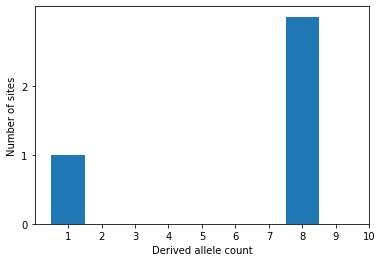

In [18]:
f, ax = plt.subplots()
# See https://stackoverflow.com/questions/30112420/histogram-for-discrete-values-with-matplotlib
# for hints :)
_ = ax.hist(unfolded_fs, np.arange(max(unfolded_fs) + 1.5) + 0.5)
ax.set_xlabel("Derived allele count")
ax.set_ylabel("Number of sites")
ax.set_xlim((0, haplotypes.shape[0]))
ax.set_xticks([i + 1 for i in range(haplotypes.shape[0])]);
ax.set_yticks([i for i in range(max(np.unique(unfolded_fs, return_counts=True)[1]))]);

## With respect to the minor allele

In [19]:
folded_fs = []
for site in range(haplotypes.shape[1]):
    counts = np.unique(haplotypes[:,site], return_counts=True)
    minor_count = counts[1].min()
    where_minor_count = np.where(counts[1] == minor_count)
    folded_fs.append(minor_count)
    print(f"Site index {site}: minor allele = {counts[0][where_minor_count]}, minor allele count = {minor_count}")

Site index 0: minor allele = ['G'], minor allele count = 2
Site index 1: minor allele = ['T'], minor allele count = 2
Site index 2: minor allele = ['T'], minor allele count = 2


Site index 3: minor allele = ['G'], minor allele count = 1


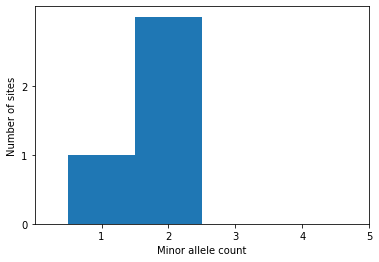

In [20]:
f, ax = plt.subplots()
# See https://stackoverflow.com/questions/30112420/histogram-for-discrete-values-with-matplotlib
# for hints :)
_ = ax.hist(folded_fs, np.arange(max(folded_fs) + 1.5) + 0.5)
ax.set_xlabel("Minor allele count")
ax.set_ylabel("Number of sites")
ax.set_xlim((0, haplotypes.shape[0] // 2))
ax.set_xticks([i + 1 for i in range(haplotypes.shape[0] // 2)]);
ax.set_yticks([i for i in range(max(np.unique(folded_fs, return_counts=True)[1]))]);

# Correlations amongst variable sites ("linkage disequilibrium")

## The (first of perhaps many) {math}`D` statistic(s).

## Pearson's squared correlation coefficient

In [21]:
for site_i in range(recoded_matrix_minor_major.shape[1]):
    for site_j in range(site_i + 1, recoded_matrix_minor_major.shape[1]):
        major = scipy.stats.pearsonr(recoded_matrix_minor_major[:,site_i], recoded_matrix_minor_major[:,site_j])
        ad = scipy.stats.pearsonr(recoded_matrix_ancestral_derived[:,site_i], recoded_matrix_ancestral_derived[:,site_j])
        major_r2 = round(major[0] ** 2, 4)
        ad_r2 = round(ad[0] ** 2, 4)
        print(f"Site pair ({site_i}, {site_j}):")
        print(f"\tr^2 between major alleles = {major_r2}.")
        print(f"\tFor derived alleles, r^2 = {ad_r2}")

Site pair (0, 1):
	r^2 between major alleles = 1.0.
	For derived alleles, r^2 = 1.0
Site pair (0, 2):
	r^2 between major alleles = 1.0.
	For derived alleles, r^2 = 1.0
Site pair (0, 3):
	r^2 between major alleles = 0.0278.
	For derived alleles, r^2 = 0.0278
Site pair (1, 2):
	r^2 between major alleles = 1.0.
	For derived alleles, r^2 = 1.0
Site pair (1, 3):
	r^2 between major alleles = 0.0278.
	For derived alleles, r^2 = 0.0278
Site pair (2, 3):
	r^2 between major alleles = 0.0278.
	For derived alleles, r^2 = 0.0278


You will note that the result is the same for the two encodings of the data.
The reason is that the statistic is *squared*, which hides the fact that, for some sites, the correlation coefficient is equal in magnitude but opposite in sign for the two encodings:

In [22]:
for site_i in range(recoded_matrix_minor_major.shape[1]):
    for site_j in range(site_i + 1, recoded_matrix_minor_major.shape[1]):
        major = scipy.stats.pearsonr(recoded_matrix_minor_major[:,site_i], recoded_matrix_minor_major[:,site_j])
        ad = scipy.stats.pearsonr(recoded_matrix_ancestral_derived[:,site_i], recoded_matrix_ancestral_derived[:,site_j])
        print(f"Site pair ({site_i}, {site_j}):")
        print(f"\tr between major alleles = {round(major[0], 4)}.")
        print(f"\tFor derived alleles, r = {round(ad[0], 4)}")

Site pair (0, 1):
	r between major alleles = 1.0.
	For derived alleles, r = 1.0
Site pair (0, 2):
	r between major alleles = 1.0.
	For derived alleles, r = 1.0
Site pair (0, 3):
	r between major alleles = -0.1667.
	For derived alleles, r = 0.1667
Site pair (1, 2):
	r between major alleles = 1.0.
	For derived alleles, r = 1.0
Site pair (1, 3):
	r between major alleles = -0.1667.
	For derived alleles, r = 0.1667
Site pair (2, 3):
	r between major alleles = -0.1667.
	For derived alleles, r = 0.1667
